## Libs Imports

In [1]:
import pandas as pd 
import json 
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import re
import warnings

##Import data and EDA

In [2]:
with open("data_the_batman.json", encoding='utf-8') as meu_json:
    data_the_batman = json.load(meu_json)

In [3]:
with open("data.json", encoding='utf-8') as meu_json:
    data = json.load(meu_json)

In [4]:
tweets = data+data_the_batman

In [66]:
df = pd.DataFrame(tweets)

In [79]:
def is_rt(col):
  try:
    if col[0]['type'] == 'retweeted':
      return True
    else:
      return False
  except:
    return False
def retweeted_name(text):
  try:
    return text.split(':')[0].split(' ')[-1]
  except:
    return None

def retweeted_id(col):
  try:
    return col[0]['id']
  except:
    return None

def retweeted_count(col):
  return col['retweet_count']

In [81]:
df['is_retweeted'] = df.referenced_tweets.apply(is_rt)
df['retweeted_name'] = None 
df.loc[df.is_retweeted == True,'retweeted_name'] = df.text.apply(retweeted_name)
df['retweeted_id'] = df.referenced_tweets.apply(retweeted_id)
df['retweeted_count'] = df.public_metrics.apply(retweeted_count)

In [82]:
df

id  ... retweeted_count
0      1492686633803694081  ...               1
1      1492686492908535809  ...               1
2      1492686424067432450  ...               1
3      1492686109461159936  ...               0
4      1492684471845494788  ...              34
...                    ...  ...             ...
23327  1492246826342391808  ...              24
23328  1492246814032076809  ...             269
23329  1492246791114432514  ...            1088
23330  1492246766778863616  ...             269
23331  1492246751096578052  ...             269

[23332 rows x 16 columns]

In [ ]:
type(tweets)

list

In [69]:
df.shape

(23332, 12)

In [68]:
df.source.value_counts()

Twitter for Android                15721
Twitter for iPhone                  4283
Twitter Web App                     2865
DCRetweetBot                         261
TweetDeck                             58
Twitter for iPad                      39
Spreaker                              22
WordPress.com                         20
Instagram                             16
mLabs - Gestão de Redes Sociais       12
Etus Brasil                           12
Twitter                                6
Hootsuite Inc.                         3
ed.edu                                 3
Revive Social App                      2
BlogsterApp                            1
Robô Jampa                             1
GDTron RT 1                            1
Blog2Social APP                        1
Tweetbot for iΟS                       1
bot número 1                           1
extinctist                             1
Careca Bot                             1
Portal Alta Definição                  1
Name: source, dt

In [73]:
df['is_retweeted'].value_counts()

True     20646
False     2686
Name: is_retweeted, dtype: int64

In [123]:
count_rt = set([(d['retweeted_name'],d['retweeted_count']) for d in df.loc[df.is_retweeted == True,['retweeted_name','retweeted_count']].to_dict('records')])

In [122]:
sorted(list(count_rt),key=lambda x:x[1],reverse=True)[5]

('@WarnerChannelBR',
 1088,
 'RT @WarnerChannelBR: "Então o Morcegão* se apaixona pela Lady Di*" #TheBatman https://t.co/CXaU6D3oJG')

In [124]:
most_imported = {}
for values in count_rt:
  if values[0] in most_imported.keys():
    if values[1] >  most_imported[values[0]]['count']:
      most_imported[values[0]]['count'] =  values[1]
  else:
    most_imported[values[0]] = {
        'name':values[0],
        'count':values[1]
    }

In [125]:
sorted(list(most_imported.values()),key=lambda x:x['count'],reverse=True)[:10]

[{'count': 2306, 'name': '@_DCCBRASIL'},
 {'count': 1090, 'name': '@WarnerChannelBR'},
 {'count': 723, 'name': '@Dc_da_depressao'},
 {'count': 667, 'name': '@SeriesBrasil'},
 {'count': 583, 'name': '@TheBatmanBRA'},
 {'count': 479, 'name': '@UniversoDCnauta'},
 {'count': 396, 'name': '@dcbrteam'},
 {'count': 392, 'name': '@merasnixx'},
 {'count': 350, 'name': '@therakemi'},
 {'count': 246, 'name': '@wbpictures_br'}]

## Create Graph

In [5]:
regex_mention = re.compile(r'(@|#).*?(:|\.|\s|\!|\?|\;)')
def get_metions(text):
  list_metion= []
  for value in regex_mention.finditer(text):
   list_metion.append(re.sub('\ |\?|\.|\!|\/|\;|\:|\,|\n|\)', '', value.group(0).replace(u'\xa0', u'')).lower())
  return list_metion

In [ ]:
print(data[0]['text'])
print(get_metions(data[0]['text']))

RT @TorreVigilancia: Imagens exclusivas do #MichaelKeaton como #Batman no set de #Batgirl por @BatgirlFilm. O longa-metragem chega ainda em…
['@torrevigilancia', '#michaelkeaton', '#batman', '#batgirl', '@batgirlfilm']


In [ ]:
graph = nx.Graph()
for twitter in tweets:
  # if twitter['text'].startswith('RT'):
  #   continue
  metions = get_metions(twitter['text'])
  for node_orig, node_target in combinations(list(metions),2):
    if graph.has_edge(node_orig, node_target):
      graph[node_orig][node_target]['weight'] += 1

    else:
      graph.add_edge(node_orig, node_target, weight=1)
biggest_componet  = None
for component in nx.connected_components(graph):
    if biggest_componet is None:
      biggest_componet = list(component)
    elif len(biggest_componet) < len(component):
      biggest_componet = list(component)
graph = graph.subgraph(biggest_componet)

## Global metrics

In [45]:
graph.number_of_nodes()

1025

In [46]:
graph.number_of_edges()

5458

In [47]:
nx.diameter(graph)

5

In [48]:
nx.radius(graph)

3

In [49]:
nx.periphery(graph)

['#cinemark',
 '@escarlategarota',
 '@mundo_cosplayer',
 '@edualexss',
 '#thebatman|',
 '@paulalovely100',
 '@peraltwspider']

In [50]:
nx.center(graph)

['#michaelkeaton',
 '#batman',
 '#batgirl',
 '#moonknight',
 '#geek',
 '@omelete',
 '@universodcnauta',
 '@hbomaxbr',
 '#dceu',
 '@dcnauta2022',
 '@info_hbomaxbr',
 '#thebatman',
 '@bigscreenleaks',
 '@_dccbrasil',
 '@batcavebr',
 '@dccomics',
 '#theflash',
 '#flash',
 '#robertpattinson',
 '#thebatmanmovie',
 '#warnerbrospictures',
 '#dc',
 '#dcu',
 '#adaonegro',
 '#aquaman2',
 '#dcheroes',
 '#panini',
 '#dccomics',
 '#quadrinhos',
 '@marlon_mmarques',
 '@therock',
 '#spiderman',
 '#nowayhome',
 '#peacemaker',
 '#vigilante',
 '#bilheteria',
 '#boxoffice',
 '#art',
 '#catwoman',
 '#aquamanandthelostkingdom',
 '#aquaman',
 '#blackadam',
 '@cinematizandoof',
 '#joker',
 '@thebatman',
 '@cinemarkoficial',
 '#superbowl',
 '#dcuniverse',
 '@wbpictures_br',
 '#robin',
 '@thebatmanbra',
 '@fandango',
 '#warnerbros',
 '#superman',
 '#adãonegro',
 '#jurassicworlddominion',
 '#cinema',
 '#filmes',
 '#normbreyfogle',
 '#pinguim',
 '#timdrake',
 '#jimstarlim',
 '#detectivecomics',
 '#johnbyrne',
 '

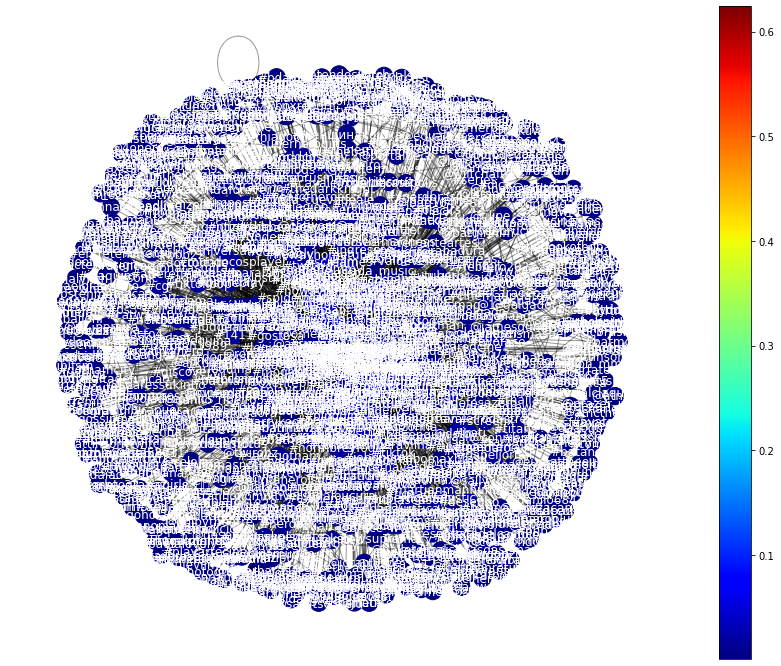

In [51]:
warnings.filterwarnings("ignore")
fig, ax = plt.subplots(1,1,figsize=(15,12))
pos = nx.spring_layout(graph,seed=123456789,k=0.5)
degree_dict = dict(nx.degree_centrality(graph))
color = list(degree_dict.values())
nx.draw_networkx_edges(graph,
                       pos=pos,
                       alpha=0.4, ax=ax)
nodes = nx.draw_networkx_nodes(graph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,ax=ax)
nx.draw_networkx_labels(graph, pos=pos,
                        font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
#plt.savefig('degree_centrality.png', transparent=True,dpi=300)
plt.show()

In [52]:
print("Top 10 nodes per degree centrality")
sorted(list(degree_dict.items()),key=lambda x:x[1],reverse=True)[:10]

Top 10 nodes per degree centrality


[('#thebatman', 0.6240234375),
 ('#batman', 0.5908203125),
 ('#dccomics', 0.2607421875),
 ('#dc', 0.1474609375),
 ('#theflash', 0.1435546875),
 ('#robertpattinson', 0.1201171875),
 ('#dceu', 0.099609375),
 ('#blackadam', 0.0908203125),
 ('#catwoman', 0.08203125),
 ('#cinema', 0.07421875)]

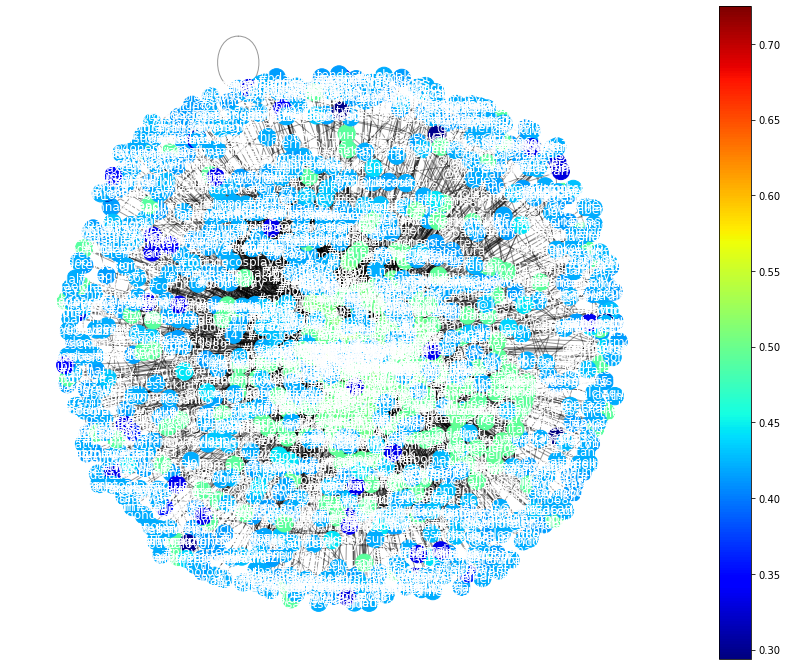

In [53]:
# the closeness centrality 
fig, ax = plt.subplots(1,1,figsize=(15,12))
pos = nx.spring_layout(graph,seed=123456789,k=0.5)
closeness_dict = dict(nx.closeness_centrality(graph))
color = list(closeness_dict.values())
nx.draw_networkx_edges(graph,
                       pos=pos,
                       alpha=0.4, ax=ax)
nodes = nx.draw_networkx_nodes(graph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)
nx.draw_networkx_labels(graph, pos=pos,
                        font_color='white', ax=ax)

plt.axis("off")
plt.colorbar(nodes)
# plt.savefig('closeness_centrality.png', transparent=True,dpi=300)
plt.show()

In [54]:
print("Top 10 nodes per closeness centrality ")
sorted(list(closeness_dict.items()),key=lambda x:x[1],reverse=True)[:10]

Top 10 nodes per closeness centrality 


[('#thebatman', 0.7246992215145082),
 ('#batman', 0.7062068965517241),
 ('#dccomics', 0.5676274944567627),
 ('#theflash', 0.5338894681960376),
 ('#dc', 0.5333333333333333),
 ('#robertpattinson', 0.526207605344296),
 ('#dceu', 0.5205897305541434),
 ('#blackadam', 0.5163893091275845),
 ('#catwoman', 0.5158690176322418),
 ('#cinema', 0.512256128064032)]

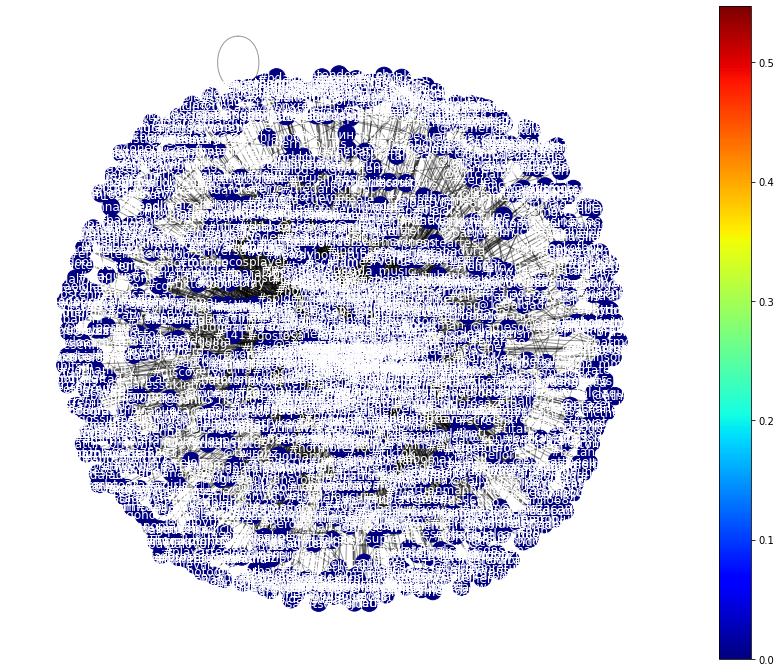

In [55]:
# the betwenness centrality 
fig, ax = plt.subplots(1,1,figsize=(15,12))
pos = nx.spring_layout(graph,seed=123456789,k=0.5)
betweenness_dict = dict(nx.betweenness_centrality(graph))
color = list(betweenness_dict.values())
nx.draw_networkx_edges(graph,
                       pos=pos,
                       alpha=0.4, ax=ax)
nodes = nx.draw_networkx_nodes(graph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)
nx.draw_networkx_labels(graph, pos=pos,
                        font_color='white', ax=ax)
plt.axis("off")
plt.colorbar(nodes)
#plt.savefig('betweenness_centrality.png', transparent=True,dpi=300)
plt.show()

In [56]:
print("Top 10 nodes per betwenness centrality ")
sorted(list(betweenness_dict.items()),key=lambda x:x[1],reverse=True)[:10]

Top 10 nodes per betwenness centrality 


[('#thebatman', 0.546799238853209),
 ('#batman', 0.4420652695974445),
 ('#dccomics', 0.055664596102696855),
 ('#theflash', 0.024658040869865595),
 ('#dc', 0.015817647593485515),
 ('#nowayhome', 0.015543818510673593),
 ('#robertpattinson', 0.010297129859261412),
 ('#blackadam', 0.009349266791798315),
 ('#dceu', 0.009240365143512078),
 ('#nerd', 0.007719221682096469)]

In [57]:
# the eigenvector centrality 
fig, ax = plt.subplots(1,1,figsize=(15,12))
pos = nx.spring_layout(graph,seed=123456789,k=0.5)
eigenvector_dict = dict(nx.eigenvector_centrality(graph))
color = list(eigenvector_dict.values())
nx.draw_networkx_edges(graph,
                       pos=pos,
                       alpha=0.4, ax=ax)
nodes = nx.draw_networkx_nodes(graph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)
nx.draw_networkx_labels(graph, pos=pos,
                        font_color='white', ax=ax)

plt.axis("off")
plt.colorbar(nodes)
#plt.savefig('eigenvector_centrality.png', transparent=True,dpi=300)
plt.show()

In [58]:
print("Top 10 nodes per eigenvector centrality ")
sorted(list(eigenvector_dict.items()),key=lambda x:x[1],reverse=True)[:10]

Top 10 nodes per eigenvector centrality 


[('#batman', 0.36626091727292054),
 ('#thebatman', 0.3287862244556762),
 ('#dccomics', 0.24061497977848317),
 ('#dc', 0.1719568793586245),
 ('#robertpattinson', 0.14839143630038712),
 ('#dceu', 0.14156466973728718),
 ('#theflash', 0.13157841366973647),
 ('#brucewayne', 0.11225244544295833),
 ('#cinema', 0.10945893897728057),
 ('#catwoman', 0.10604714369269175)]

## Network Decomposition Analysis

In [61]:
G = graph.copy()

In [62]:
G.remove_edges_from(nx.selfloop_edges(G))

In [63]:
G.number_of_nodes()

1025

In [64]:
set([v for k,v in nx.core_number(G).items()])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 25}

In [65]:
# the degree of network
fig, ax = plt.subplots(1,1,figsize=(10,8))

# Find k-cores
G_core_19 = nx.k_shell(G, 19)
G_core_25 = nx.k_core(G, 25)

# layout position
pos = nx.spring_layout(G,seed=123456789,k=0.3)

# draw edges
nx.draw_networkx_edges(G,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(G,
                 pos=pos,
                 node_color="#333333")

# draw nodes
nodes = nx.draw_networkx_nodes(G_core_19,
                 pos=pos,
                 node_color="blue")

nodes = nx.draw_networkx_nodes(G_core_25,
                 pos=pos,
                 node_color="red")

# static legend
red_patch = mpatches.Patch(color='red', label='25-core')
blue_patch = mpatches.Patch(color='blue', label='19-shell')
plt.legend(handles=[red_patch,blue_patch])

plt.axis("off")
#plt.savefig('k-core_sociopatterns.png', transparent=True,dpi=600)
plt.show()